# Prévision de production solaire à J+1 en temps réel

L'objectif de ce projet est de designer un modèle de prévision capable de produire, avec des données publiques de production solaire (RTE) ainsi que des prévisions météorologiques (Open-météo), la production solaire d'une région française à J+1.

## Source et insights données

Les données utilisées pour cette analyse et l'entrainement des modèles proviennent de l'API OpenData RTE pour la production solaire régionale, ainsi que de l'API OpenMétéo pour les données météorologiques. Les données sont à la maille horaire et couvrent 2 ans et demi : du 01/01/2023 au 22/05/2025..
Les données météorologiques relevées sont issues de l'analyse barycentrique des capacités installées dans la région. Par suite, les mesures de dispersion comme l'écart min-max ou la dispersion (std) sont issues de la moyenne des barycentres départementaux, pour essayer de capturer la variance spatiale sans utiliser (pour l'instant) de CNN. Dans la suite, nous qualifierons de scénario central (SC) les données issues du barycentre régional.

Le dataset contient 20 064 records et 49 features (48 inputs et 1 output), détaillées en dessous : 

**Variables d'entrées**

*Variables SC* 
1. temperature_2m : Température en degrés celsius (°C) ;
2. sunshine_duration : Nombre représentant la durée en secondes d'ensoleillement (s) ;
3. is_day : Booléen représentant si nous sommes en journée ou dans la nuit ;
4. relative_humidity_2m : Nombre représentant l'humidité à 2 mètres du sol (g/m3) ;
5. precipitation : Nombre représentant la quantité d'eau tombée par m2 (mm) ; 
6. surface_pressure : Nombre représentant la pression à la surface (Pascal) ;
7. cloud_cover : Pourcentage représentant la couverture nuageuse ou la nébulosité ;
8. wind_speed_10m : Vitesse du vent à 10 mètres du sol (m/s) ;
9. wind_direction_10m : Direction du vent (degrés) ;
10. direct_radiation : Nombre représentant le rayonnement solaire atteignant directement la surface terreste depuis le soleil sans rencontrer d'obstacles (W/m²) ;
11. diffuse_radiation : Nombre représentant le rayonnement solaire indirect, induit par la dispersion de la lumière dans les nuages et les particules atmosphériques (W/m²) ;
12. direct_normal_irradiance : L'irradiation normale directe (DNI) est la quantité de rayonnement solaire reçue par unité de surface par une surface qui est toujours maintenue perpendiculaire (ou normale) aux rayons qui arrivent en ligne droite depuis la direction du soleil à sa position actuelle dans le ciel (W/m²) ;
13. shortwave_radiation : Nombre représentant l'énergie produite par le soleil avec des longueurs d'onde allant de l'infrarouge à l'ultraviolet en passant par le visible (W/m²) ; 
14. global_tilted_irradiance : L'irradiation solaire est la puissance par unité de surface (densité de puissance de surface) reçue du Soleil sous forme de rayonnement électromagnétique dans la gamme de longueurs d'onde de l'instrument de mesure (W/m²) ;
15. terrestrial_radiation : Le rayonnement à ondes longues est un rayonnement thermique électromagnétique émis par la surface de la Terre, l'atmosphère et les nuages. Il est également appelé rayonnement terrestre (W/m²) ; 
16. apparent_temperature : Nombre représentant la combinaison de l'air ambiant combiné à l'humidité. On peut parler de température ressentie (°C)

*Autres variables de dispersion départementales*
17. X_delta_minmax : Ecart entre le minimum et le maximum des précédentes valeurs relevées dans les différents départements constitutifs de la région ;
18. X_std : Ecart-type des précédentes valeurs relevées dans les différents départements constitutifs de la région ;

**Variables de sorties (SC)**

1. Solaire (MW) : La production solaire en MW pour la région étudiée à la maille horaire.

### Import des librairies

In [1]:
# Import de librairies
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Test statistiques
from scipy.stats import jarque_bera, shapiro

# Structure du signal temporel
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

In [2]:
# Confirmation d'être à la racine du dossier
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
os.chdir(project_root)

### Data global inspection 

In [3]:
# Import data
df = pd.read_csv("data/processed/exploratory_solar_dataset.csv", sep=";", index_col=0)

In [4]:
def inspect_dataframe(df: pd.DataFrame) -> None:
    
    """Inspection de la structure du dataframe"""

    #Inspection générale
    print(f'Shape: {df.shape}') #Forme
    print(f'Types de données {df.dtypes.value_counts()}') #dtypes
    print(f"Index: {type(df.index).__name__}")
    
    # Regard sur les duplicatas
    print(f'Duplicatas : {df.duplicated().sum()} ; {df.duplicated().sum()/len(df)*100:.0f}%')

    # Aperçu des données
    print("\n--- Premières lignes ---")
    display(df.head())
    print("\n--- Dernières lignes ---")
    display(df.tail())


In [5]:
inspect_dataframe(df)

Shape: (20064, 49)
Types de données float64    49
Name: count, dtype: int64
Index: Index
Duplicatas : 0 ; 0%

--- Premières lignes ---


,Solaire (MW),temperature_2m_run_13,sunshine_duration_run_13,is_day_run_13,relative_humidity_2m_run_13,precipitation_run_13,surface_pressure_run_13,cloud_cover_run_13,wind_speed_10m_run_13,wind_direction_10m_run_13,...,direct_normal_irradiance_delta_minmax,direct_normal_irradiance_std,shortwave_radiation_delta_minmax,shortwave_radiation_std,global_tilted_irradiance_delta_minmax,global_tilted_irradiance_std,terrestrial_radiation_delta_minmax,terrestrial_radiation_std,apparent_temperature_delta_minmax,apparent_temperature_std
2023-02-01 01:00:00+01:00,0.0,3.136,0.0,0.0,99.29538,0.0,974.73560,100.0,6.989936,304.50858,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.2179,2.4873
2023-02-01 02:00:00+01:00,0.0,3.436,0.0,0.0,99.64800,0.0,974.41766,100.0,8.089994,302.27563,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.8490,2.3038
2023-02-01 03:00:00+01:00,0.0,3.436,0.0,0.0,99.29709,0.0,974.41766,100.0,9.178235,281.30990,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.6066,1.9406
2023-02-01 04:00:00+01:00,0.0,3.436,0.0,0.0,98.59856,0.1,974.04000,100.0,9.693296,291.80148,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0427,1.7014
2023-02-01 05:00:00+01:00,0.0,3.436,0.0,0.0,99.29709,0.6,974.04000,100.0,10.587918,305.31128,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.8898,1.7487



--- Dernières lignes ---


,Solaire (MW),temperature_2m_run_13,sunshine_duration_run_13,is_day_run_13,relative_humidity_2m_run_13,precipitation_run_13,surface_pressure_run_13,cloud_cover_run_13,wind_speed_10m_run_13,wind_direction_10m_run_13,...,direct_normal_irradiance_delta_minmax,direct_normal_irradiance_std,shortwave_radiation_delta_minmax,shortwave_radiation_std,global_tilted_irradiance_delta_minmax,global_tilted_irradiance_std,terrestrial_radiation_delta_minmax,terrestrial_radiation_std,apparent_temperature_delta_minmax,apparent_temperature_std
2025-05-16 21:00:00+02:00,73.5,14.036000,1684.2335,1.0,73.322000,0.0,962.17224,54.0,7.059122,289.35907,...,192.6246,53.6356,38.0,10.2156,38.0,10.2156,60.3306,18.6558,7.6204,2.2760
2025-05-16 22:00:00+02:00,17.0,11.636001,0.0000,0.0,81.556460,0.0,962.39044,12.0,5.091168,278.13000,...,0.0000,0.0000,1.0,0.5064,1.0,0.5064,14.6844,5.6219,7.3349,2.3324
2025-05-16 23:00:00+02:00,0.0,10.736000,0.0000,0.0,85.116035,0.0,962.60065,1.0,4.353619,262.87510,...,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0000,7.3030,2.3273
2025-05-17 00:00:00+02:00,0.0,10.436000,0.0000,0.0,84.506960,0.0,963.01720,0.0,2.500640,239.74365,...,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0000,7.1966,2.2962
2025-05-17 01:00:00+02:00,0.0,9.686000,0.0000,0.0,85.584140,0.0,962.78110,0.0,2.189795,189.46225,...,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0000,7.3655,2.2721


**Insights :**

- **Le dataset contient 20 064 records et 49 features (48 imputs et 1 output)** ;
- Les 49 features sont numériques ;
- Pas de duplicatas observés ;
- Toutes les colonnes sont des flottantes, alors que la **colonne is_day devrait être un booléen.**

In [6]:
df.isna().sum()

Solaire (MW)                             2
temperature_2m_run_13                    0
sunshine_duration_run_13                 0
is_day_run_13                            0
relative_humidity_2m_run_13              0
precipitation_run_13                     0
surface_pressure_run_13                  0
cloud_cover_run_13                       0
wind_speed_10m_run_13                    0
wind_direction_10m_run_13                0
direct_radiation_run_13                  0
diffuse_radiation_run_13                 0
direct_normal_irradiance_run_13          0
shortwave_radiation_run_13               0
global_tilted_irradiance_run_13          0
terrestrial_radiation_run_13             0
apparent_temperature_run_13              0
temperature_2m_delta_minmax              0
temperature_2m_std                       0
sunshine_duration_delta_minmax           0
sunshine_duration_std                    0
is_day_delta_minmax                      0
is_day_std                               0
relative_hu

Le dataset contient 2 valeurs manquantes sur la colonne output.

In [7]:
nan_values = df[df["Solaire (MW)"].isna()]
print(nan_values.head())

                           Solaire (MW)  temperature_2m_run_13  \
2023-10-29 02:00:00+02:00           NaN                 12.686   
2024-10-27 02:00:00+02:00           NaN                 10.836   

                           sunshine_duration_run_13  is_day_run_13  \
2023-10-29 02:00:00+02:00                       0.0            0.0   
2024-10-27 02:00:00+02:00                       0.0            0.0   

                           relative_humidity_2m_run_13  precipitation_run_13  \
2023-10-29 02:00:00+02:00                     66.40961                   0.0   
2024-10-27 02:00:00+02:00                     98.35062                   0.3   

                           surface_pressure_run_13  cloud_cover_run_13  \
2023-10-29 02:00:00+02:00                 949.9066                89.0   
2024-10-27 02:00:00+02:00                 961.2005               100.0   

                           wind_speed_10m_run_13  wind_direction_10m_run_13  \
2023-10-29 02:00:00+02:00              18.07902

Ces valeurs manquantes semblent être isolées, de plus les mesures sont de nuit, ce qui implique une production d'énergie nulle.

Propositions : 
- Imputation de la valeur à la valeur précédente ;
- Délétions simples des lignes.

In [8]:
df.describe().astype(int)

,Solaire (MW),temperature_2m_run_13,sunshine_duration_run_13,is_day_run_13,relative_humidity_2m_run_13,precipitation_run_13,surface_pressure_run_13,cloud_cover_run_13,wind_speed_10m_run_13,wind_direction_10m_run_13,...,direct_normal_irradiance_delta_minmax,direct_normal_irradiance_std,shortwave_radiation_delta_minmax,shortwave_radiation_std,global_tilted_irradiance_delta_minmax,global_tilted_irradiance_std,terrestrial_radiation_delta_minmax,terrestrial_radiation_std,apparent_temperature_delta_minmax,apparent_temperature_std
count,20062,20064,20064,20064,20064,20064,20064,20064,20064,20064,...,20064,20064,20064,20064,20064,20064,20064,20064,20064,20064
mean,563,12,1143,0,78,0,962,65,13,203,...,222,73,104,33,104,33,25,7,7,2
std,772,6,1620,0,16,0,7,41,9,91,...,277,94,152,49,152,49,26,7,2,0
min,0,-4,0,0,20,0,928,0,0,2,...,0,0,0,0,0,0,0,0,2,0
25%,0,7,0,0,66,0,959,19,6,119,...,0,0,0,0,0,0,0,0,6,1
50%,79,11,0,1,82,0,963,94,12,239,...,42,13,12,3,12,3,25,7,7,2
75%,1034,16,3600,1,93,0,966,100,19,290,...,467,145,174,53,174,53,48,14,8,2
max,3380,36,3600,1,100,13,984,100,52,360,...,963,386,787,277,787,277,74,21,18,5


**Résumé de l'inspection** :
- **Le dataset contient 20 064 records et 49 features (48 imputs et 1 output)** ;
- Les 49 features sont numériques ;
- Pas de duplicatas observés ;
- Toutes les colonnes sont des flottantes, alors que la **colonne is_day devrait être un booléen.**

**Données manquantes** :
- Seules valeurs de production solaire sont manquantes, en pleine nuit :
  - Suppression ou imputation à la valeur précédente proposée

In [9]:
# Temporal data, indexed
df.index = pd.to_datetime(df.index, utc=True).tz_convert("Europe/Paris")

### Analyse univariée

Dans un premier temps nous étudierons la variable cible, la production solaire *Solaire (MW)*. 

#### Analyse de la target variable **Solaire_mw**

In [10]:
df = df.rename(columns={"Solaire (MW)" : "solar_mw"}) #name standard

In [11]:
series = df.solar_mw.copy()
series.describe().astype(int)

count    20062
mean       563
std        772
min          0
25%          0
50%         79
75%       1034
max       3380
Name: solar_mw, dtype: int32

**Key points** :
- Près de 25% des valeurs sont nulles (cycles jour/nuit sûrement avec couverture nuageuse marginalement) -> A tester ;
- La valeur maximale est de 3.4 GW, inférieure à la capacité installée dans la région Occitanie (> 3.7 GW) ;
- L'écart-type est plus élevé que la moyenne, signifiant une très grande dispersion (saisonnalité).

#### Répartition des heures nulles

In [12]:
prod_df = series[series > 0].to_frame(name="solar_mw")
prod_df["hour"] = prod_df.index.hour
prod_df["month"] = prod_df.index.month
prod_df["year"] = prod_df.index.year
print(prod_df.head())


                           solar_mw  hour  month  year
2023-02-01 07:00:00+01:00     24.50     7      2  2023
2023-02-01 08:00:00+01:00     98.25     8      2  2023
2023-02-01 09:00:00+01:00    439.75     9      2  2023
2023-02-01 10:00:00+01:00    908.50    10      2  2023
2023-02-01 11:00:00+01:00   1247.50    11      2  2023


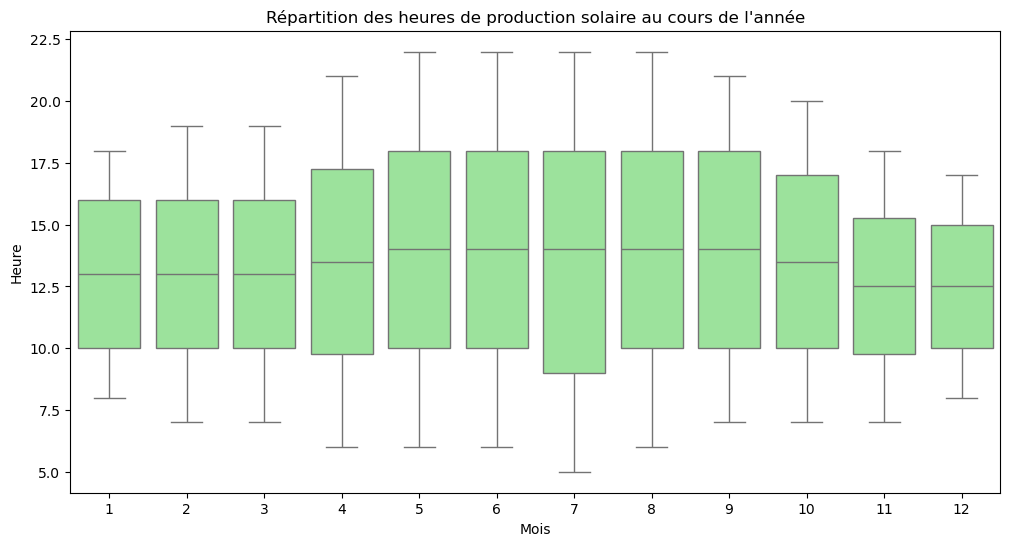

In [13]:
fig = plt.figure(figsize=(12, 6))
plt.title("Répartition des heures de production solaire au cours de l'année")
sns.boxplot(data=prod_df, x="month", y="hour", color="lightgreen")
plt.xlabel("Mois")
plt.ylabel("Heure")
plt.show()

Il peut être observé que la plage des heures de production suit la saisonnalité des cycles solaires, avec un pic aux heures de l'après-midi, et enfin avec aucune valeur aberrante (>23h, <5h).

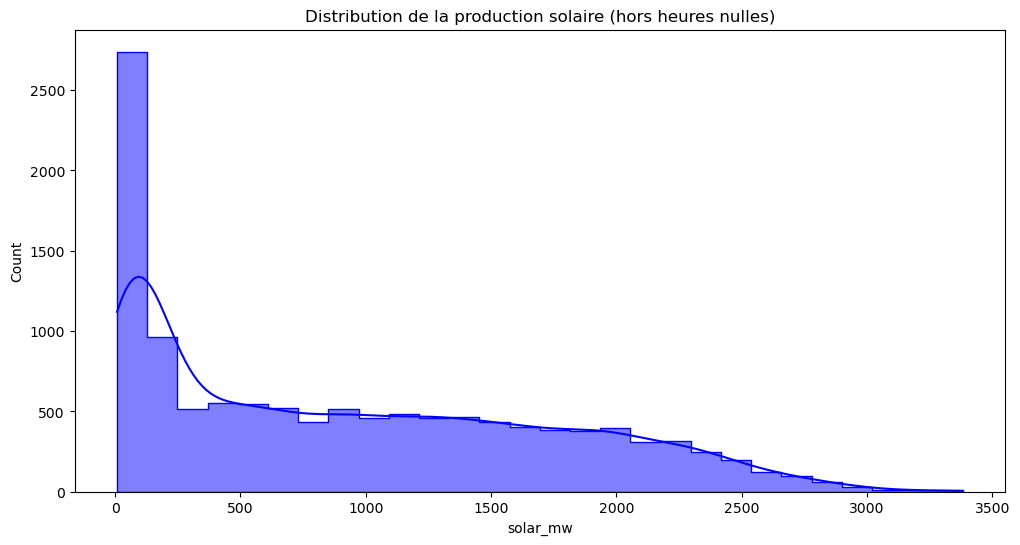

Kurtosis : -0.8484671958593482
Skewness : 0.552612659508762


In [14]:
# Check des caractéristiques de la distribution
fig = plt.figure(figsize=(12, 6))
sns.histplot(prod_df["solar_mw"], element="step", color="blue", kde=True)
plt.title("Distribution de la production solaire (hors heures nulles)")
plt.show()

# Quelques tests
solar_series = prod_df.solar_mw.copy()
print(f'Kurtosis : {solar_series.kurt()}')
print(f'Skewness : {solar_series.skew()}')

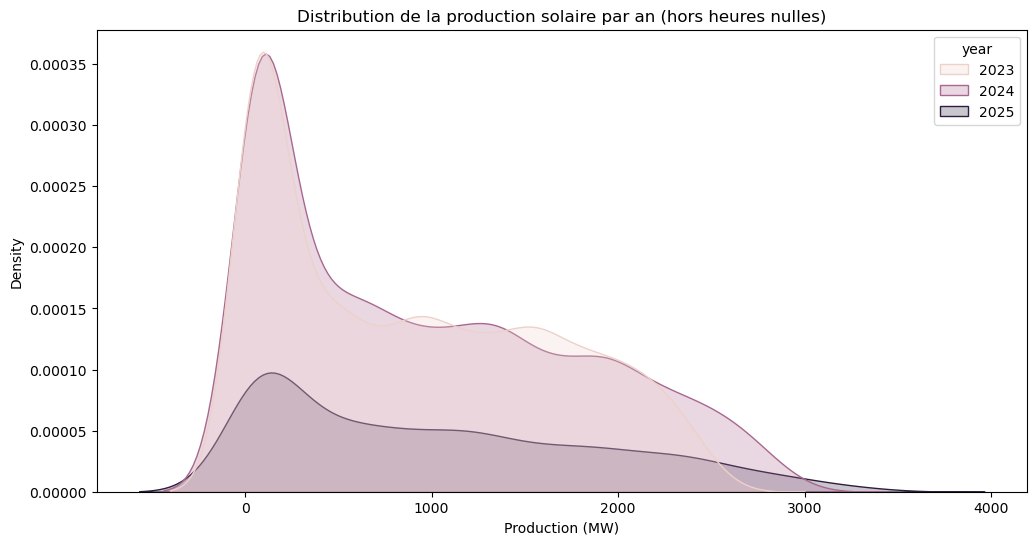

In [15]:
plt.figure(figsize=(12,6))
sns.kdeplot(data=prod_df, x='solar_mw', hue='year', fill=True)
plt.title("Distribution de la production solaire par an (hors heures nulles)")
plt.xlabel("Production (MW)")
plt.show()

**Key points** :
- La distribution est asymétrique à droite (visualisation et skewness), ce qui est intuitif pour la production solaire (très grands pics, avec en moyenne des valeurs faibles (conditions météorologiques)) ;
- La distribution est plutôt écrasée (kurtosis < 0), ce qui signifie que les évènements rares sont moins fréquents qu'une loi normale. Cela raisonne avec l'écart-type très élevé trouvé en première approche, qui montre des valeurs plus étalées autour de la moyenne ;
- Il est aussi possible de remarquer que l'augmentation de la capacité installée se remarque sur le graphique en distribution annuelle. Chaque année voit la production maximale augmenter, autant en proportion qu'en absolue (2025 non terminée). Le même comportement est observé sur les valeurs faibles sur les années 2023 - 2024.

La production solaire est donc très variable mais sans évènements extrêmes récurrents, conditionnée par les conditions météorologiques. Souvent, les conditions sont sous-optimales ne permettent pas une production maximale, avec quelques rares évènements météorologiques où la production est quasi-maximale à l'échelle de toutes les centrales solaires de la région.

#### Analyse des covariables

Dans la littérature, les variables physiquement impactantes sur la production des panneaux solaires sont les variables de radiation *direct_radiation*, *diffuse radiation* et *shortwave_radiation*, l'irradiance *global_tilted_irradiance*, la durée d'ensoleillement *sunshine_duration*, la température *temperature_2m*, la nébulosité *cloud_cover* et la variable catégorielle de journée *is_day*. Nous commencerons donc par analyser ces dernières.

##### Variables numériques

In [16]:
# Imputation des features temporelles
df["hour"] = df.index.hour
df["dayofweek"] = df.index.dayofweek
df["month"] = df.index.month
df["year"] = df.index.year

In [17]:
#Filtrage sur les données de journée
df = df[df["sunshine_duration_run_13"] > 0]

In [18]:
def statistical_univariate_analysis(subdf: pd.DataFrame, row_fig: int, col_fig: int, figsize: tuple) -> None: 
    """Produis des violinplot sur une grille de taille (row_fig, col_fig), la figure de taille figsize, sur les variables contenues dans le df 'subdf'.

    Args:
        subdf (pd.DataFrame): Variables où l'on veut analyser leurs distributions
        row_fig (int): Nombre de lignes sur la grille subplot
        col_fig (int): Nombre de colonnes sur la grille subplot
        figsize (tuple): tuple de taille de la figure
    """
    fig, axs = plt.subplots(row_fig, col_fig, figsize=figsize)
    fig.suptitle(f'Analyse univariée (violinplot)', fontsize=16)
    axs = axs.flatten()
    col_list = subdf.columns

    for axe, col in enumerate(col_list):

        if "std" in col:
            sns.violinplot(subdf[col], ax=axs[axe], color="beige")
        elif "minmax" in col:
            sns.violinplot(subdf[col], ax=axs[axe], color="palegoldenrod")   
        else:
            sns.violinplot(subdf[col], ax=axs[axe], color="gold")

        axs[axe].set_title(f"Distribution de {col}")
    
    plt.show()

In [19]:
# Filtrage variables irradiance

col_filter = [col for col in df.columns if "global_tilted_irradiance" in col]
c3 = [col for col in df.columns if "direct_normal_irradiance" in col]
col_filter += c2
print(col_filter, len(col_filter))

NameError: name 'c2' is not defined

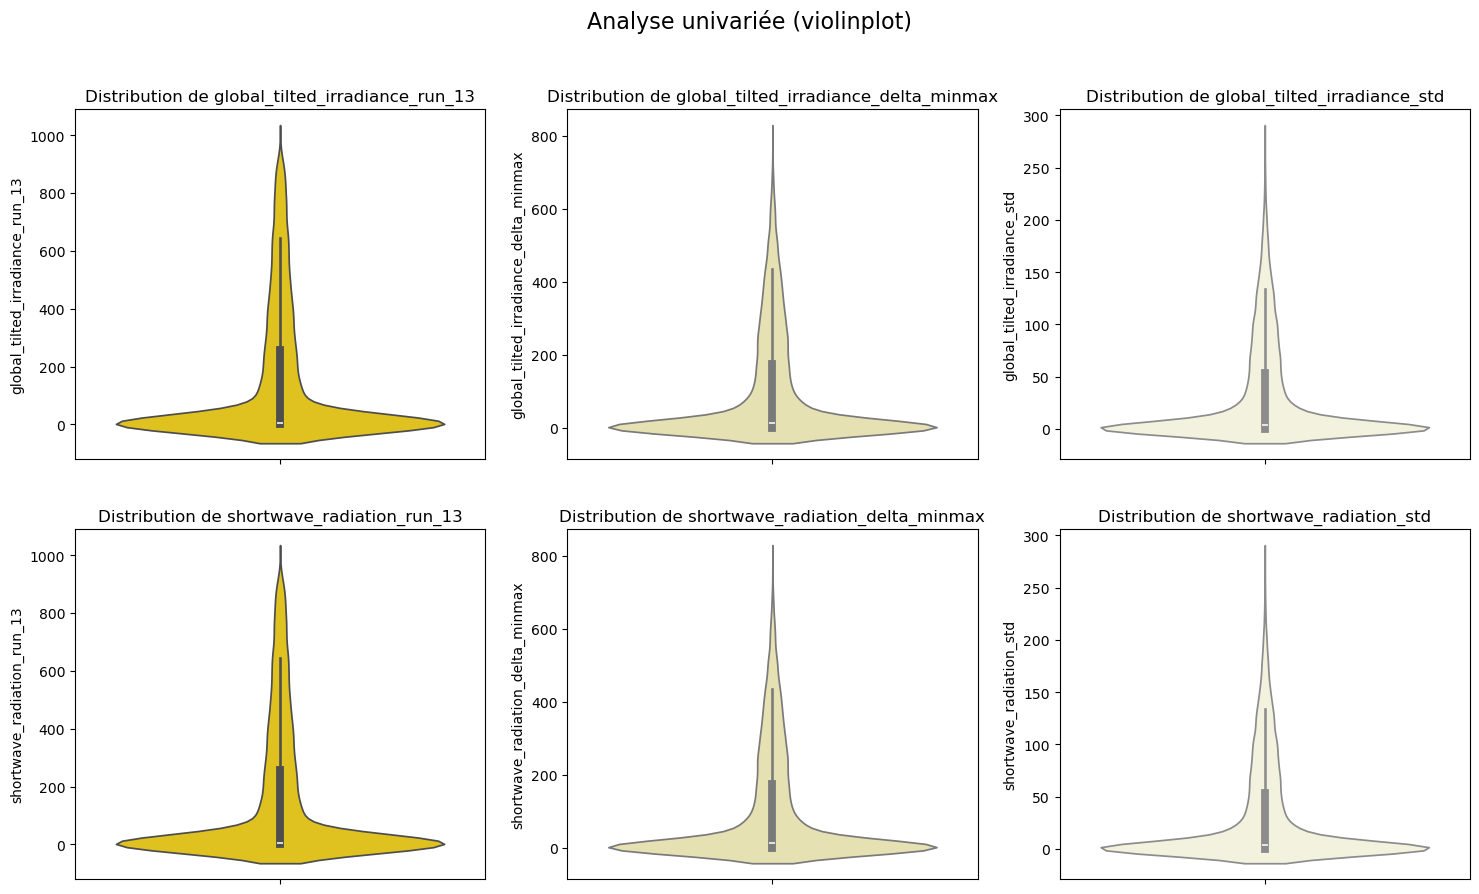

In [ ]:
statistical_univariate_analysis(df[col_filter], 2, 3, (18, 10))

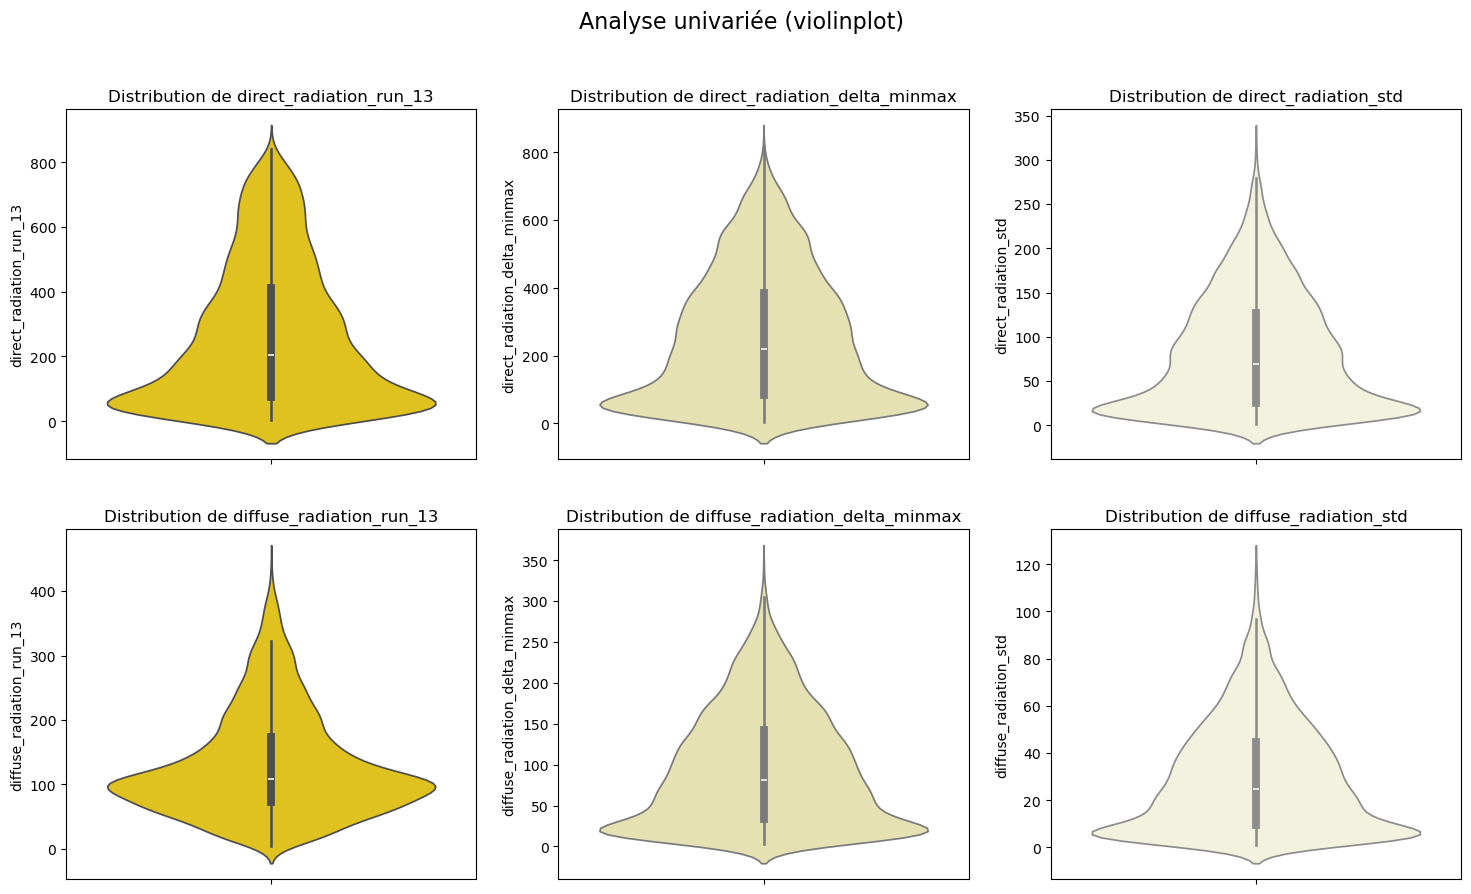

In [ ]:
c3 = [col for col in df.columns if "direct_radiation" in col]
c4 = [col for col in df.columns if "diffuse_radiation" in col]
c5 = c3 + c4
statistical_univariate_analysis(df[c5], 2, 3, (18, 10))

Interprétation ici

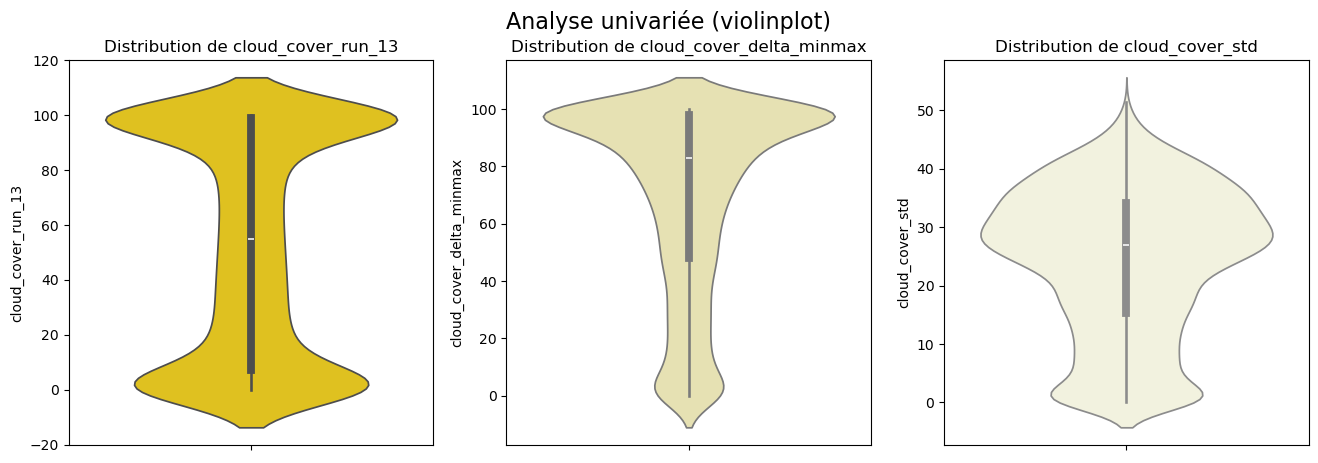

In [ ]:
c5 = [col for col in df.columns if "cloud" in col]
statistical_univariate_analysis(df[c5], 1, 3, (16, 5))

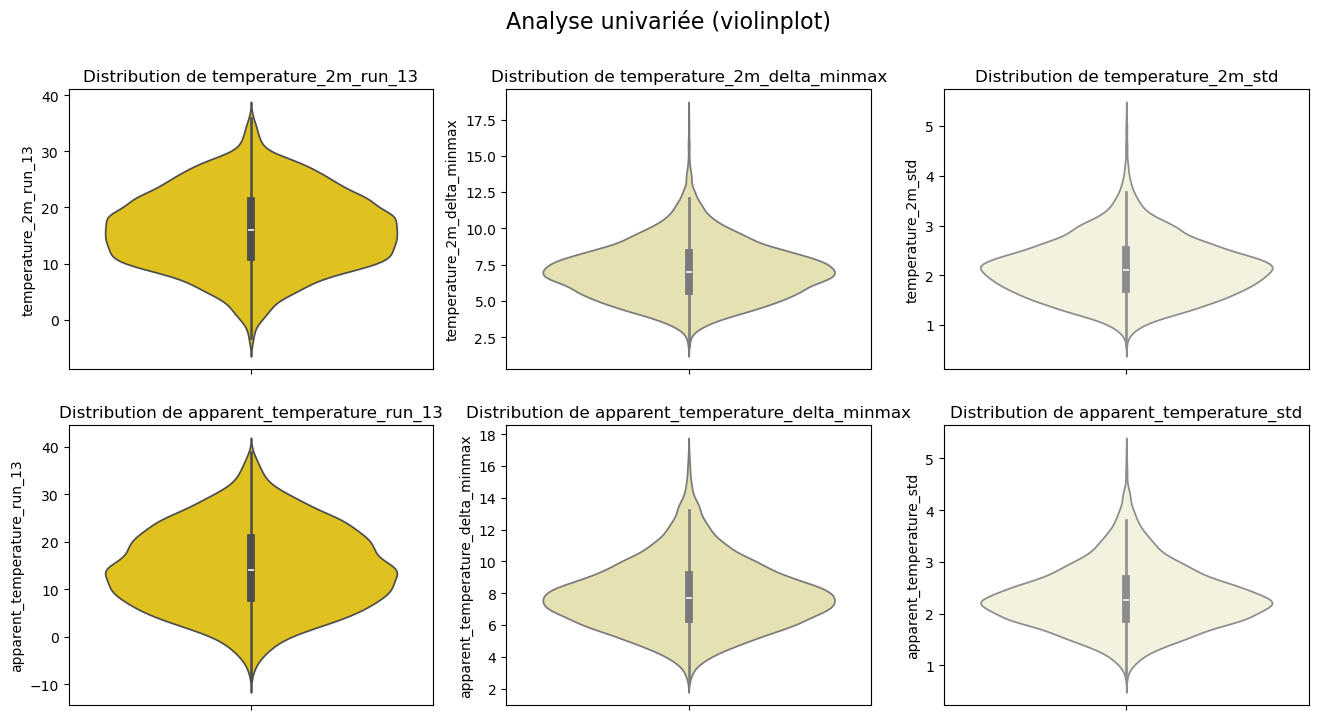

In [ ]:
c6 = [col for col in df.columns if "temperature_2m" in col]
c7 = [col for col in df.columns if "apparent_temperature" in col]
statistical_univariate_analysis(df[c6+c7], 2, 3, (16, 8))

In [ ]:
print(jarque_bera(df["temperature_2m_run_13"]))

SignificanceResult(statistic=43.71494209379053, pvalue=3.216776859853138e-10) SignificanceResult(statistic=105.85814490438464, pvalue=1.0308510123326056e-23)


#### Variables catégorielles

In [ ]:
df.columns

Index(['solar_mw', 'temperature_2m_run_13', 'sunshine_duration_run_13',
       'is_day_run_13', 'relative_humidity_2m_run_13', 'precipitation_run_13',
       'surface_pressure_run_13', 'cloud_cover_run_13',
       'wind_speed_10m_run_13', 'wind_direction_10m_run_13',
       'direct_radiation_run_13', 'diffuse_radiation_run_13',
       'direct_normal_irradiance_run_13', 'shortwave_radiation_run_13',
       'global_tilted_irradiance_run_13', 'terrestrial_radiation_run_13',
       'apparent_temperature_run_13', 'temperature_2m_delta_minmax',
       'temperature_2m_std', 'sunshine_duration_delta_minmax',
       'sunshine_duration_std', 'is_day_delta_minmax', 'is_day_std',
       'relative_humidity_2m_delta_minmax', 'relative_humidity_2m_std',
       'precipitation_delta_minmax', 'precipitation_std',
       'surface_pressure_delta_minmax', 'surface_pressure_std',
       'cloud_cover_delta_minmax', 'cloud_cover_std',
       'wind_speed_10m_delta_minmax', 'wind_speed_10m_std',
       'wind_di

### Analyse bivariée (TODO)

In [ ]:
def corr_viz(df: pd.DataFrame) -> tuple:
    
    """_summary_

    Args:
        df (pd.DataFrame): _description_

    Returns:
        pd.DataFrame: _description_
    """
    
    corr_pearson = df.corr(method="pearson")
    corr_spearman = df.corr(method="spearman")
     
    return corr_pearson, corr_spearman

In [ ]:
corr_pearson, corr_spearman = corr_viz(df)

<Axes: >

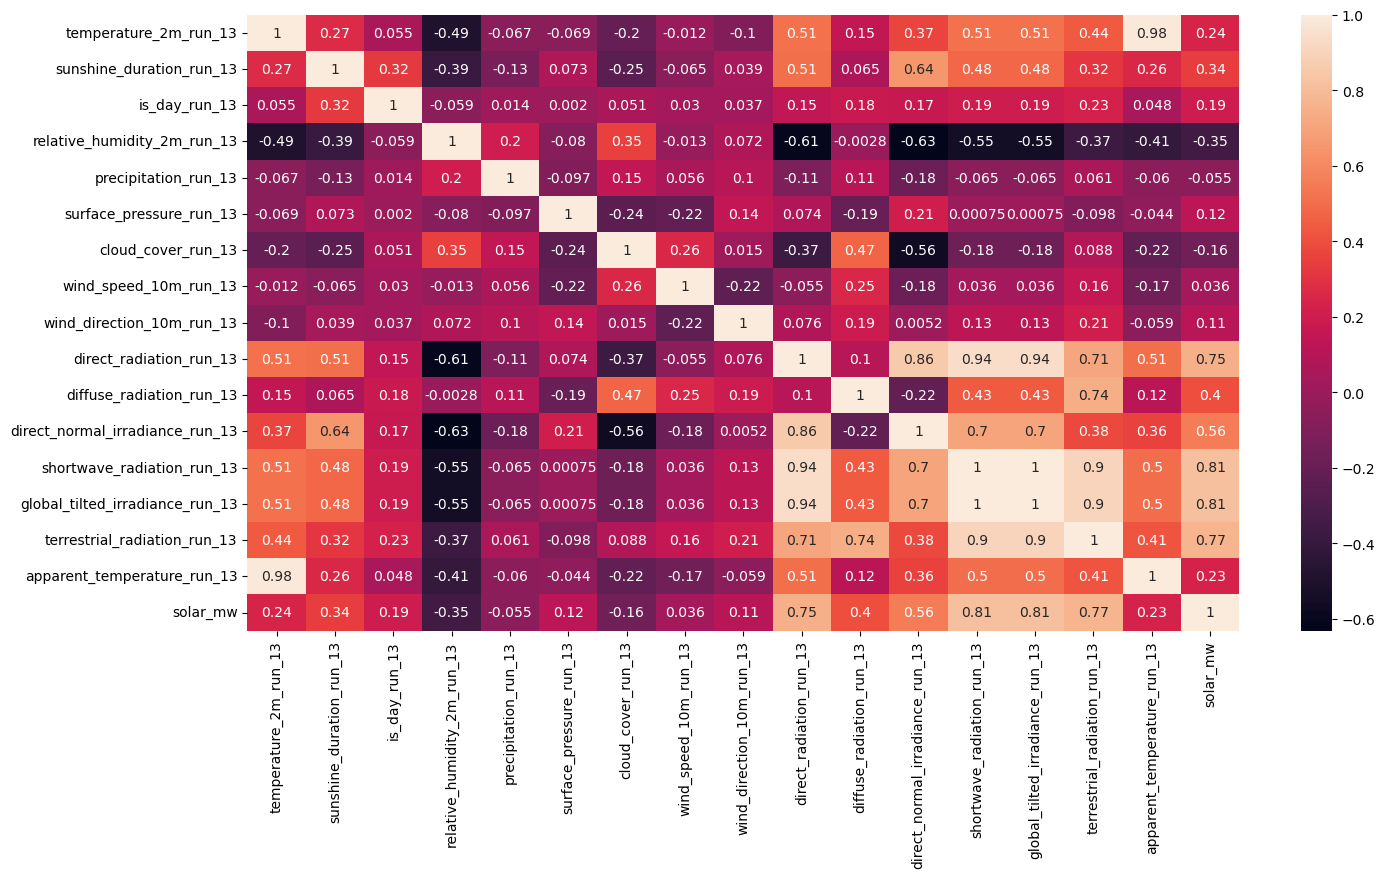

In [ ]:
col_filter = [col for col in corr_spearman.columns if "run_13" in col] + ["solar_mw"]
fig = plt.figure(figsize=(16,8))
sns.heatmap(corr_pearson.loc[col_filter, col_filter], annot=True)

### Analyse temporelle (TODO)

#### Visualisation annuelle

In [ ]:
df = pd.read_csv("data/processed/exploratory_solar_dataset.csv", sep=";", index_col=0)
df = df.rename(columns={"Solaire (MW)" : "solar_mw"})
df.index = pd.to_datetime(df.index, utc=True).tz_convert("Europe/Paris")

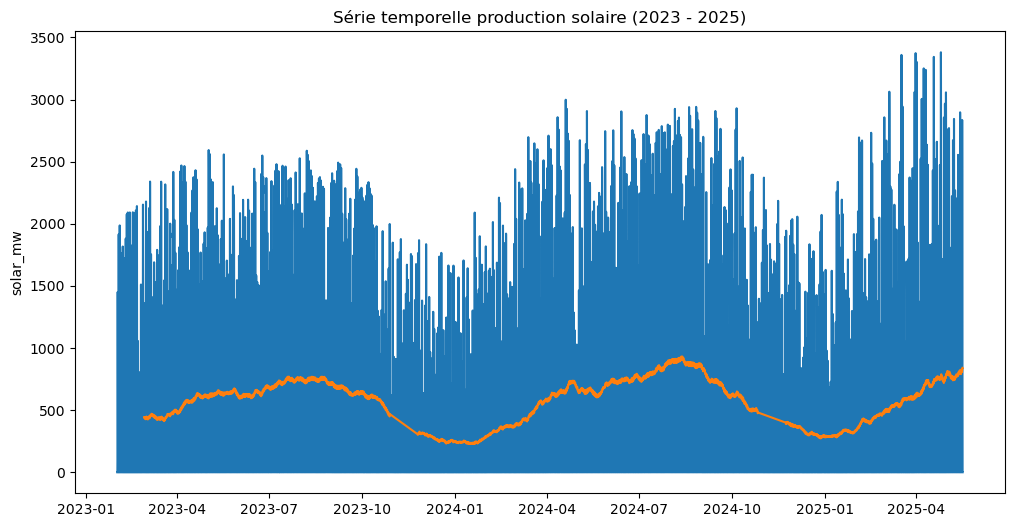

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.title("Série temporelle production solaire (2023 - 2025)")
solar_ts = df["solar_mw"].copy()
sns.lineplot(solar_ts)
sns.lineplot(solar_ts.rolling(640).mean())
plt.show()

Il peut déjà être remarqué une **dérive positive à l'échelle annuelle** (sûrement due à l'augmentation de la capacité totale installée sur le territoire), ainsi qu'une saisonnalité annuelle (saison hiver-été), que l'on peut intuitivement corréler à l'irradiance. Nous pouvons de plus regarder la structure de la série temporelle pour 72 heures. On peut s'attendre à une saisonnalité journalière corrélée au cycle solaire.

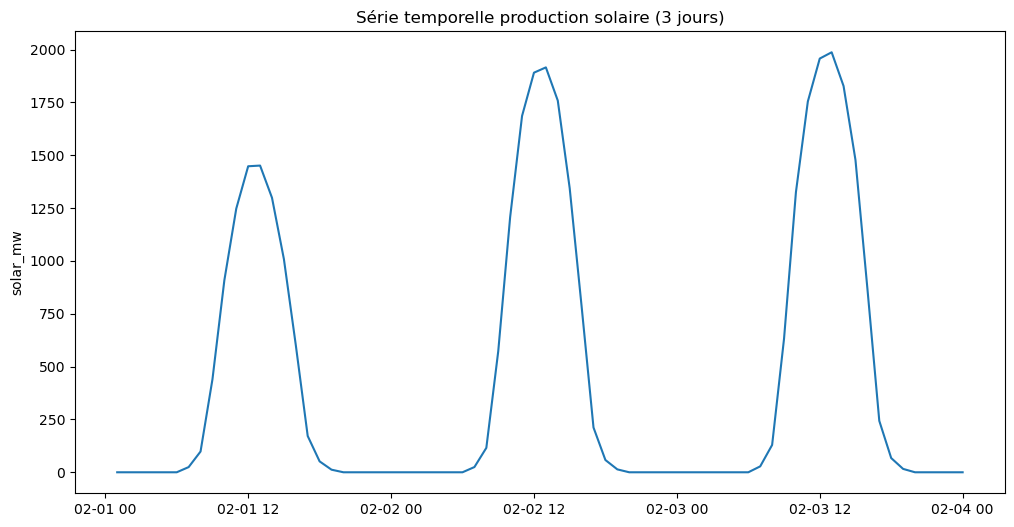

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.title("Série temporelle production solaire (3 jours)")
sns.lineplot(solar_ts[:72])
plt.show()

Nous observons évidemment une saisonnalité journalière correspondant au cycle solaire. Regardons maintenant l'autocorrélation et l'autocorrélation partielle de la série sur 96 lags ( 4 jours).

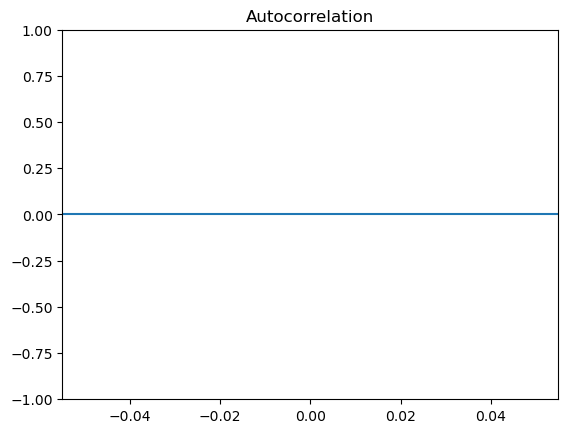

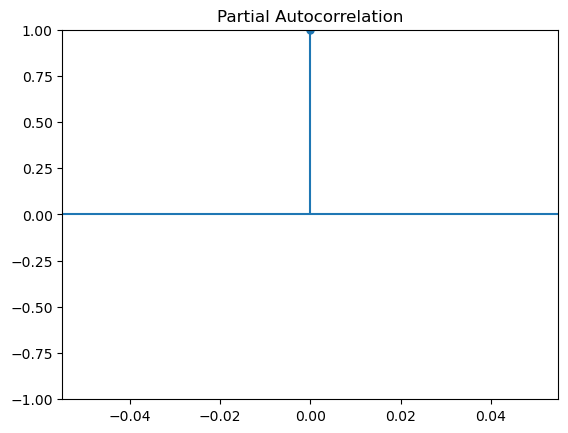

In [ ]:
plot_acf(solar_ts, lags=96)
plot_pacf(solar_ts, lags=96)
plt.show()

Il semble nécessaire d'effectuer une différenciation saisonnière d'ordre 24 pour regarder la stationnarité de la série et l'ACF/PACF ensuite pour les ordres MA et AR.

In [ ]:
# Différenciation saisonnière d'ordre 24
solar_ts_diff24 = solar_ts.diff(24).dropna()

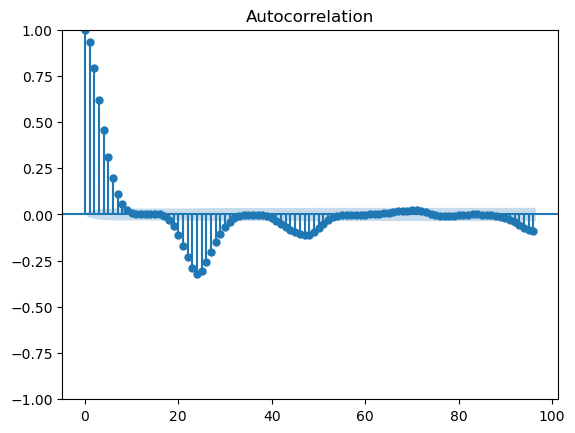

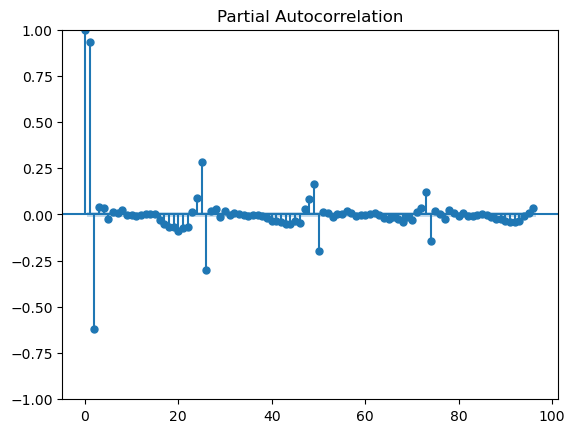

In [ ]:
plot_acf(solar_ts_diff24, lags=96)
plot_pacf(solar_ts_diff24, lags=96)
plt.show()

In [ ]:
def stationnarity_test(time_series: pd.Series) -> None :
    """Regarde la stationnarité faible (adfuller)"""
    
    result_ad = adfuller(solar_ts_diff24)
    print(f'Résultats adfuller : {result_ad}')
    print(f'Résultats adfuller : {result_ad}')

In [ ]:
stationnarity_test(solar_ts_diff24)

Résultats adfuller : (-28.19638350591497, 0.0, 46, 19989, {'1%': -3.4306771869508563, '5%': -2.8616846051286564, '10%': -2.566846969359512}, 229665.70851566707)


Nous pouvons remarquer que la différenciation saisonnière a bien marché et a supprimé complètement la saisonnalité principale. de plus le test d'adfuller indique que la série est stationnaire (-28 bien inférieur aux valeurs critiques, et p-value négligeable).
Concernant l'ordre AR : 
- La PACF indique une coupure nette après le lag 1, on peut donc proposer en première approche un modèle AR(1) ;
- L'ACF décroit rapidement en dessous de 0.25 après 10 lags, et le pattern stationnaire a été supprimé. Cela indique une structure avec moyenne mobile (MA). Nous pouvons donc proposer en première approche pour le premier modèle les paramètres suivant : **SARIMAX(1,0,q)(0,1,0)_24**. Le paramètre de la moyenne mobile peut-être retrouvée avec une méthode itérative basée sur une minimisation d'une métrique choisie (MAE, AIC... selon problématique métier).